In [1]:
train_name = "vqc_powell_yy" 

Separar datasets de treinamento e teste, separar as features que serão utilizadas.
Preencher nan com a média de valores da coluna.  // Testar também normalização [0;pi]

In [2]:
import numpy as np
import pandas as pd

In [3]:
train = pd.read_csv("../dataset/train_normalized.csv")
test = pd.read_csv("../dataset/test_normalized.csv")

In [4]:
y_train = train['label']
y_test = test['label']

## FEATURE SELECTION

In [5]:
selected_features = ["proto", "orig_bytes", "conn_state", "resp_pkts", "resp_ip_bytes"]
num_features = len(selected_features)

In [6]:
train = train[selected_features]
test = test[selected_features]

In [7]:
train.head(5)

,proto,orig_bytes,conn_state,resp_pkts,resp_ip_bytes
0,0.5,0.000000e+00,0.000000,0.000000,0.000000e+00
1,0.5,0.000000e+00,0.000000,0.000000,0.000000e+00
2,0.5,0.000000e+00,0.000000,0.000000,0.000000e+00
3,0.5,0.000000e+00,0.000000,0.000000,0.000000e+00
4,0.5,2.382635e-07,0.833333,0.000017,6.178160e-07


Definir o Label para treinamento (característica que se quer prever)

## FEATURE MAP

YYFeatureMap

Nº de features = tamanho do vetor de features

FeatureMap = ZZFeatureMap com dimensões nº de features e 1 repetição

Decompose e draw FeatureMap, output "mpl", fold = 40

In [8]:
from qiskit.circuit.library import PauliFeatureMap

feature_map = PauliFeatureMap(num_features, reps = 1, paulis=["YY"])

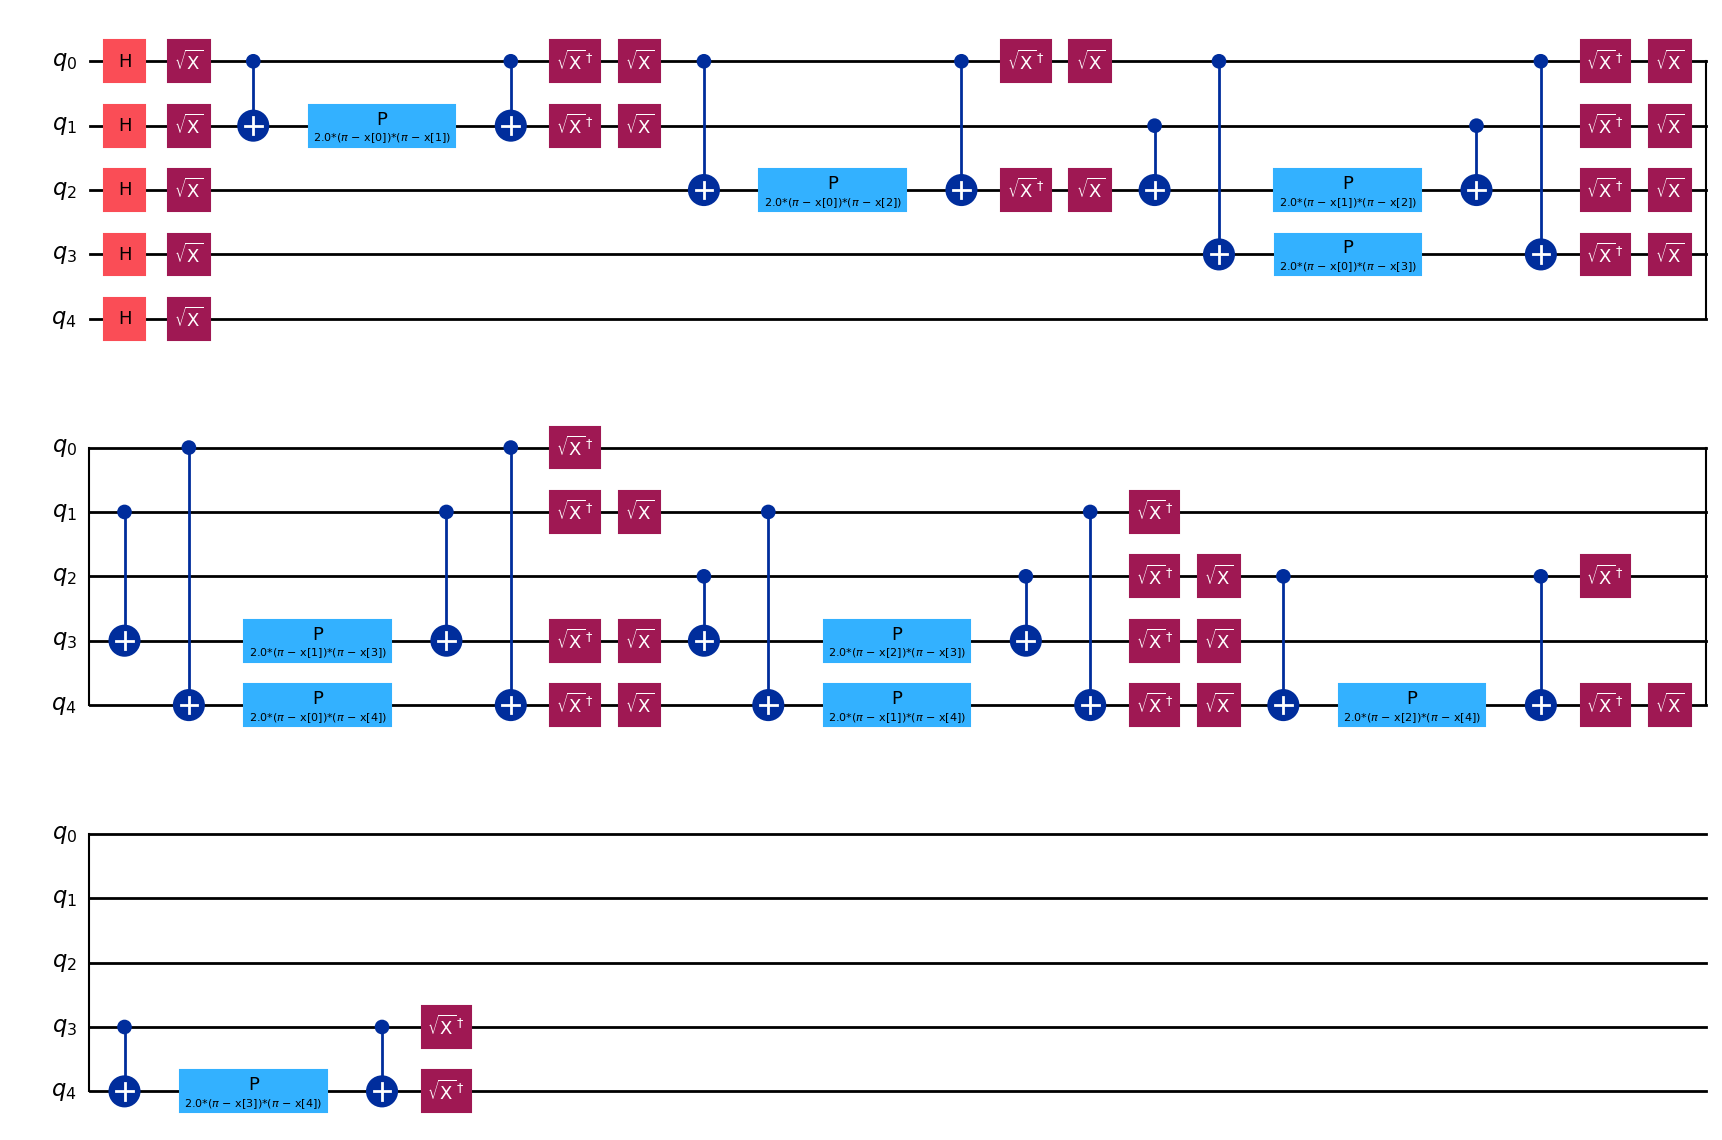

In [9]:
feature_map.decompose().draw(output = "mpl", fold = 25)

## Ansatz

#### TwoLocal
https://docs.quantum.ibm.com/api/qiskit/qiskit.circuit.library.TwoLocal -> ENTENDER MELHOR

TwoLocal.__Subclasses__() -> Ansatz = RealAmplitudes com nº de qubits = nº de features e 2 repetições

Decompose e draw Ansatz, output "mpl", fold = 20

In [10]:
from qiskit.circuit.library import RealAmplitudes
ansatz = RealAmplitudes(num_features, reps = 2)

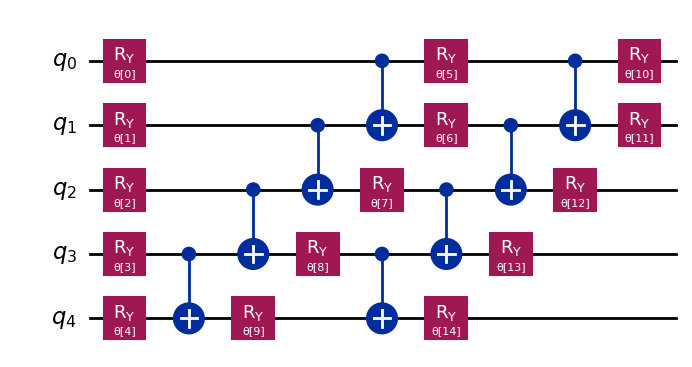

In [11]:
ansatz.decompose().draw(output = "mpl", fold = 40)

## OTIMIZADOR

#### POWELL

Rodar com configurações padrão.

In [12]:
from qiskit_machine_learning.optimizers import POWELL
optimizer = POWELL(maxiter=100)

## SAMPLER
Erro no VQC, checar motivo

Importar Sampler, shots=512 -> https://docs.quantum.ibm.com/api/qiskit/qiskit.primitives.StatevectorSampler

In [13]:
from qiskit.primitives import StatevectorSampler

sampler = StatevectorSampler()

## Callback Function
Importar pyplot para plotar gráfico da função custo pelas iterações - callback_graph

In [14]:
from matplotlib import pyplot as plt
from IPython.display import clear_output

objective_func_vals = []
plt.rcParams["figure.figsize"]= (12,6)

def callback_graph(weights, obj_func_eval): #
    clear_output(wait=True)
    objective_func_vals.append(obj_func_eval)
    plt.title("Função de Custo")
    plt.xlabel("Iterações")
    plt.ylabel("Função de Custo")
    plt.plot(range(len(objective_func_vals)), objective_func_vals)
    plt.show()
    


## VQC
Importar classificador VQC do Qiskit -> https://github.com/qiskit-community/qiskit-machine-learning // https://qiskit-community.github.io/qiskit-machine-learning/getting_started.html#installation

VQC { sampler = sampler; feature_map = feature_map, ansatz = ansatz; optimizer = optimizer; callback = callback_graph }

Importar time para visualizar o tempo de execução

VQC.fit(train_features, train_labels.values)

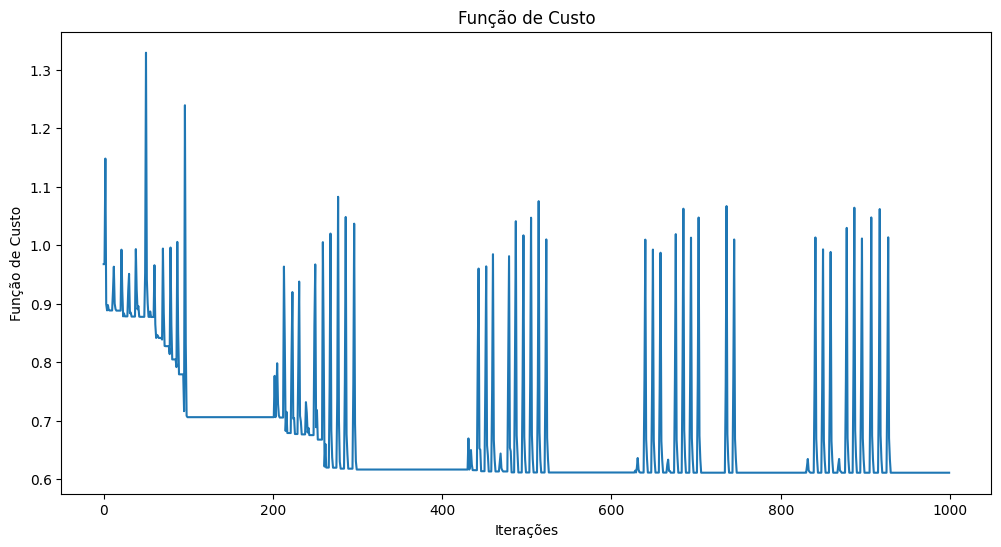

Training time: 47023 seconds


In [15]:
import time
from qiskit_machine_learning.algorithms.classifiers import VQC
from qiskit_aer import *
from qiskit.transpiler.preset_passmanagers import generate_preset_pass_manager

sim = AerSimulator(method='statevector', device='GPU')

vqc = VQC(
    #sampler=sampler,
    feature_map=feature_map,
    ansatz=ansatz,
    optimizer=optimizer,
    callback=callback_graph,
    pass_manager=generate_preset_pass_manager(backend=sim)
)

start = time.time()
vqc.fit(train, y_train.values)
elapsed = time.time() - start

vqc.save(f'trained_models/{train_name}.model')


print(f"Training time: {round(elapsed)} seconds")

In [16]:
print(objective_func_vals)

[0.967386608094582, 0.967386608094582, 1.1478869432641334, 0.8989427222515772, 0.8883313333118447, 0.8973177457580346, 0.888906180572367, 0.8881502109751328, 0.8881560184504745, 0.8881585376251103, 0.8881502109751328, 0.92134942453852, 0.9630090581119117, 0.8999250205894089, 0.8905908180633291, 0.8879171935121509, 0.8878912678332648, 0.8878899627279172, 0.8878899450884449, 0.8878899818289018, 0.8878899450884449, 0.9921100161558052, 0.9214492301320039, 0.8780965098614838, 0.8831931305610288, 0.8780641760419408, 0.8780643793655178, 0.87806571345, 0.8780641760419408, 0.9217244383175925, 0.9507468548600153, 0.88346864149679, 0.8846334101403186, 0.8777187203664791, 0.8777107499045951, 0.8777107411303864, 0.8777108010700059, 0.8777107411303864, 0.993055943010404, 0.9238622547940041, 0.8902047279244317, 0.8956454980276695, 0.8777090507246303, 0.8772775612182718, 0.8772773774596546, 0.8772772649123068, 0.8773389388926865, 0.8772773163289775, 0.8772772649123068, 0.9522792035440719, 1.3289174042

In [17]:
train_acc = vqc.score(train, y_train)
print(f'Acuracia: {round(train_acc,2)*100}%')

Acuracia: 95.0%


Rodar com o teste -> VQC.predict(test);

Realizar avaliação dos resultados (acurácia, precisão, recall...)

In [18]:
y_predicted = vqc.predict(test)

y_predicted

array([1., 1., 1., ..., 1., 1., 1.])

In [19]:
import sklearn.metrics as metrics
print(metrics.classification_report(y_test, y_predicted))

              precision    recall  f1-score   support

         0.0       1.00      0.84      0.92      6575
         1.0       0.93      1.00      0.96     13655

    accuracy                           0.95     20230
   macro avg       0.97      0.92      0.94     20230
weighted avg       0.95      0.95      0.95     20230



In [20]:
confusion_matrix = metrics.confusion_matrix(y_test, y_predicted)
print(confusion_matrix)

tn, fp, fn, tp = metrics.confusion_matrix(y_test, y_predicted).ravel()

print(tn, fp, fn, tp)

[[ 5550  1025]
 [    0 13655]]
5550 1025 0 13655
